In [1]:
from datetime import datetime

TIME_SCOPE_BEGIN = datetime(1900, 1, 1, 0, 0, 0)
TIME_SCOPE_END = datetime(2015, 11, 30, 0, 0, 0) # exclusively

In [2]:
from data_source import nytimes
from datetime import datetime
from datetime import timedelta

time = TIME_SCOPE_BEGIN
end_time = TIME_SCOPE_END

map_time_articles = {}
while time < end_time:
    articles = nytimes.get_articles_for_day(time)
    
    map_time_articles[time] = articles

    time = time + timedelta(days=1)

In [3]:
articles_count = 0
for key in map_time_articles:
    articles_count += len(map_time_articles[key])

print articles_count, 'articles were loaded'

422236 were loaded


In [3]:
from datetime import datetime, timedelta

def remove_duplicates(articles):
    filter_set = set()
    
    filtered_articles = []
    for article in articles:
        if article['title'].lower() in filter_set:
            continue
        
        filtered_articles.append(article)
        filter_set.add(article['title'].lower())
    return filtered_articles

def get_articles_for_period(start_time, end_time):
    all_articles = []
    
    time = start_time
    while time < end_time:
        if time not in map_time_articles:
            time = time + timedelta(days=1)
            continue
        
        articles = map_time_articles[time]
        all_articles = all_articles + articles
        
        time = time + timedelta(days=1)
    
    all_articles = remove_duplicates(all_articles)
    return all_articles

In [4]:
map_TimeSemantics = {}
def calculate_semantics_changes(time, articles):
    neg_count = 0
    pos_count = 0

    from textblob import TextBlob
    for article in articles:
        blob = TextBlob(article['title'])

        if blob.sentiment.polarity > 0:
            pos_count += 1
        elif blob.sentiment.polarity < 0:
            neg_count += 1

    if time.year in map_TimeSemantics:
        map_TimeSemantics[time.year]['pos'] += pos_count
        map_TimeSemantics[time.year]['neg'] += neg_count
    else:
        map_TimeSemantics[time.year] = {
            'pos': pos_count,
            'neg': neg_count
        }

for key in map_time_articles:
    articles = map_time_articles[key]
    calculate_semantics_changes(key, articles)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


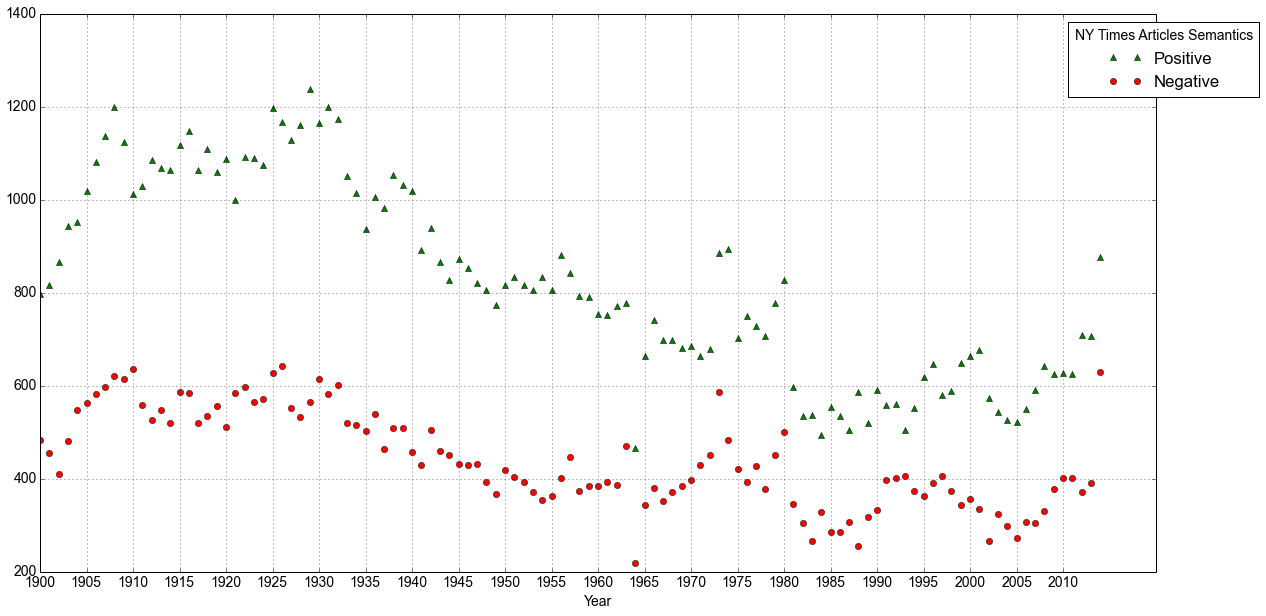

/usr/lib/pymodules/python2.7/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


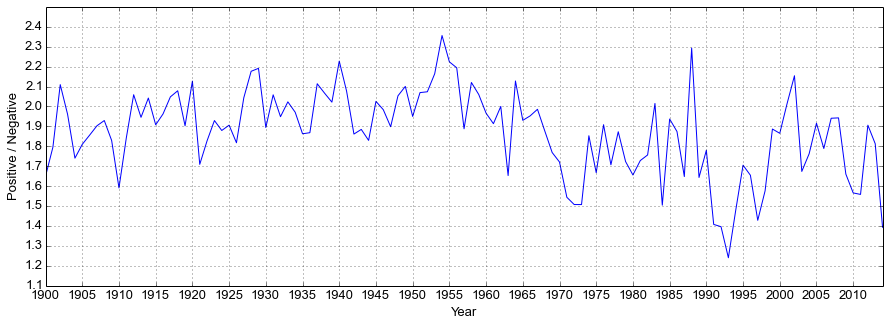

In [5]:
start_year = TIME_SCOPE_BEGIN.year
end_year = TIME_SCOPE_END.year

x_axis = [x for x in range(start_year, end_year)]
y_pos_axis = [map_TimeSemantics[x]['pos'] for x in range(start_year, end_year)]
y_neg_axis = [map_TimeSemantics[x]['neg'] for x in range(start_year, end_year)]

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 14})

x_ticks = [x for x in range(min(x_axis), max(x_axis), 5)]

plt.figure(figsize=(20, 10))
plt.plot(x_axis, y_pos_axis, 'g^', label='Positive')
plt.plot(x_axis, y_neg_axis, 'ro', label='Negative')
plt.xticks(x_ticks)
plt.xlabel('Year')
plt.grid()
plt.legend(title='NY Times Articles Semantics', bbox_to_anchor=(1.1, 1.0))
plt.show()

pos_neg_correlation = [x*1.0/y for x,y in zip(y_pos_axis, y_neg_axis)]
from numpy import arange
y_min = round(min(pos_neg_correlation) - 0.1, 1)
y_max = round(max(pos_neg_correlation) + 0.1, 1)
y_ticks = arange(y_min, y_max, 0.1)

matplotlib.rcParams.update({'font.size': 13})

plt.figure(figsize=(15, 5))
plt.plot(x_axis, pos_neg_correlation)
plt.axis([min(x_axis), max(x_axis), y_min, y_max])
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.xlabel('Year')
plt.ylabel('Positive / Negative')
plt.grid()
plt.legend(title='NY Times Articles Semantics Correlation')
plt.show()

In [9]:
import numpy as np
array = np.array(pos_neg_correlation)

print 'Mean', np.mean(array)
print 'Standard Deviation', np.std(array)

Mean 1.87127076826
Standard Deviation 0.210659920994


In [5]:
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime, timedelta
from textblob import TextBlob
from textblob.blob import WordList

WORD_CLOUD_STOPWORDS = []

def get_year_words(year):
    time = datetime(year, 1, 1, 0, 0, 0)
    end_time = datetime(year+1, 1, 1, 0, 0, 0)
    
    all_words_list = WordList([])
    
    all_articles = get_articles_for_period(time, end_time)
    for article in all_articles:
        blob = TextBlob(article['title'])
            
        word_list = blob.words.singularize()
            
        all_words_list = all_words_list + word_list
        
        time = time + timedelta(days=1)
        
    return all_words_list


def print_word_cloud_for_words(all_words, extra_stopwords = None):
    if len(all_words) == 0:
        print 'No words supplied'
        return
    
    text = ' '.join(all_words)
    
    #querywords = text.split()
    global WORD_CLOUD_STOPWORDS
    
    #all_stopwords = WORD_CLOUD_STOPWORDS
    #if extra_stopwords is not None:
    #    all_stopwords = all_stopwords + extra_stopwords
        
    #resultwords  = [word for word in querywords if word.lower() not in all_stopwords]
    #text = ' '.join(resultwords)
    
    all_stopwords = STOPWORDS
    all_stopwords = all_stopwords.union(set(WORD_CLOUD_STOPWORDS))
    if extra_stopwords is not None:
        all_stopwords = all_stopwords.union(set(extra_stopwords))
    
    wordcloud = WordCloud(background_color="white", stopwords=all_stopwords)
    wordcloud.generate(text)
    
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")

        
def print_word_cloud_for_year(year):
    all_words = get_year_words(year)

    print_word_cloud_for_words(all_words)

In [22]:
from nltk.corpus import stopwords
WORD_CLOUD_STOPWORDS = stopwords.words('english')
WORD_CLOUD_STOPWORDS = WORD_CLOUD_STOPWORDS + [
    'new', 'news', 'time', 'york', 'title', 'say', 'will', 'article',
    'hi', 'year', 'mr', 'pro', 'page', 'man', 'today', 'city', 'notice',
    'paid', 'n\'t'
] + [chr(i) for i in range(ord('a'), ord('z')+1)]

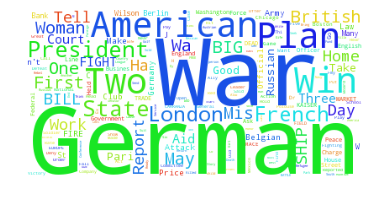

In [7]:
print_word_cloud_for_year(1914) # first world war begins

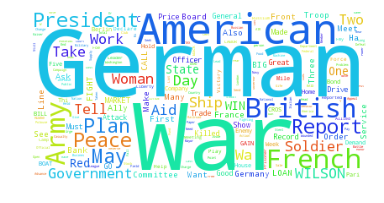

In [45]:
print_word_cloud_for_year(1918) # first world war ends

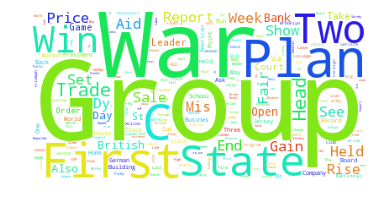

In [46]:
print_word_cloud_for_year(1939) # second world war begins

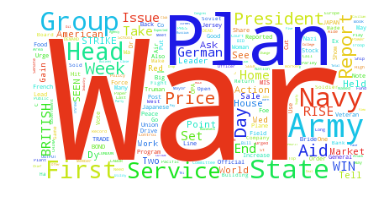

In [27]:
print_word_cloud_for_year(1945) # second world war ends

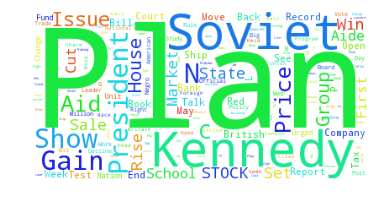

In [28]:
print_word_cloud_for_year(1963) # kennedy killed 

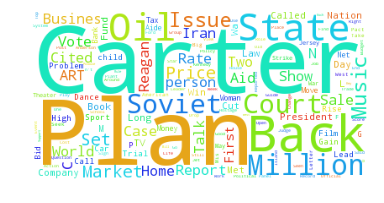

In [29]:
print_word_cloud_for_year(1980)

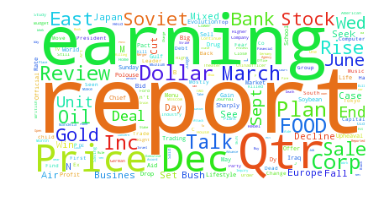

In [30]:
print_word_cloud_for_year(1990)

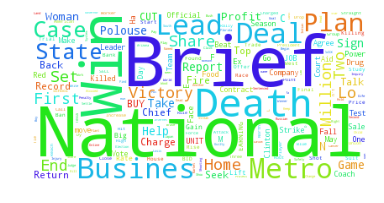

In [31]:
print_word_cloud_for_year(2000)

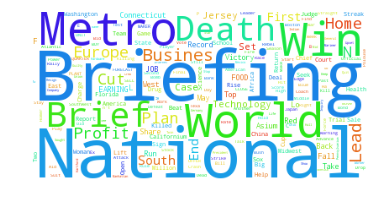

In [32]:
print_word_cloud_for_year(2001) # 11 September

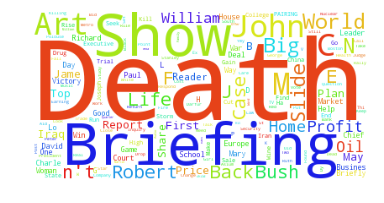

In [33]:
print_word_cloud_for_year(2005)

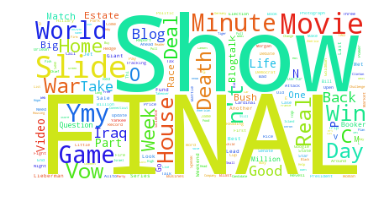

In [34]:
print_word_cloud_for_year(2006)

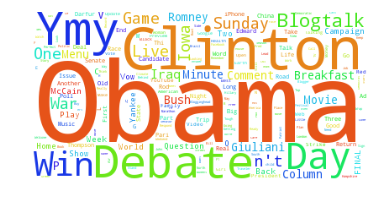

In [35]:
print_word_cloud_for_year(2007)

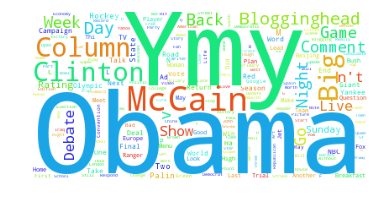

In [36]:
print_word_cloud_for_year(2008) # world economic crisis

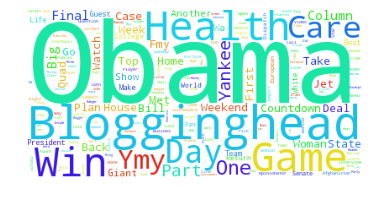

In [19]:
print_word_cloud_for_year(2009)

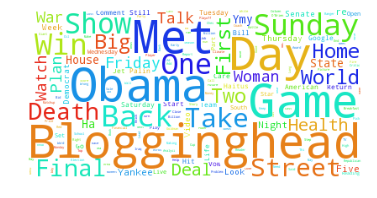

In [23]:
print_word_cloud_for_year(2010)

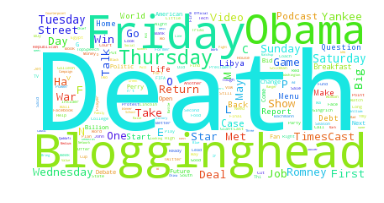

In [39]:
print_word_cloud_for_year(2011)

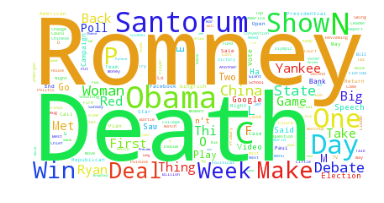

In [40]:
print_word_cloud_for_year(2012)

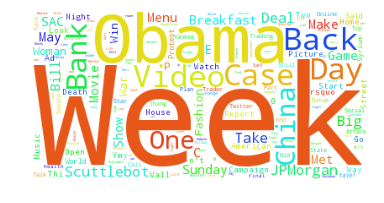

In [41]:
print_word_cloud_for_year(2013)

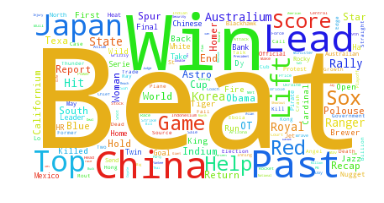

In [42]:
print_word_cloud_for_year(2014)

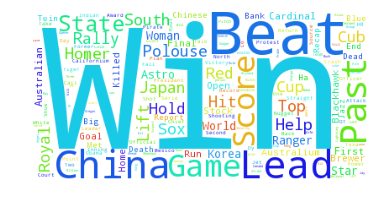

In [43]:
print_word_cloud_for_year(2015)

In [7]:
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime, timedelta
from textblob import TextBlob
from textblob.blob import WordList

def compute_word_semantics(articles, word):
    map_semantics = {
        'pos': 0,
        'neg': 0,
        'neutral': 0,
        'words': WordList([]),
        'articles': []
    }
    neg_count = 0
    pos_count = 0
    neutral_count = 0

    from textblob import TextBlob
    for article in articles:           
        blob = TextBlob(article['title'])
        
        if word.lower() not in article['title'].lower():
            continue

        if blob.sentiment.polarity > 0:
            pos_count += 1
        elif blob.sentiment.polarity < 0:
            neg_count += 1
        else:
            neutral_count += 1
            
        map_semantics['words'] = map_semantics['words'] + blob.words.singularize()
        map_semantics['articles'].append((article, blob.sentiment.polarity))

    map_semantics['pos'] = pos_count
    map_semantics['neg'] = neg_count
    map_semantics['neutral'] = neutral_count
    
    return map_semantics

Positive mentions for word ukraine is equeal to 6
Negative mentions for word ukraine is equeal to 2
Neutral mentions for word ukraine is equeal to 16

Kerry to Hold Talks With Ukraine's Opposition in Germany 0.0
Talks to Broker Settlement in Ukraine Are Nearing an End-EU Source 0.0
U.S. Ready to Assist Ukraine Return to Democracy: Lew 0.2
UK's Osborne Says Ready to Provide Assistance to Ukraine Through IMF, EU 0.2
Times Minute | Ukraine ‘Tourists’ Rally 0.0
Russia says ousted Yanukovich is legal president of Ukraine 0.2
Putin Says Still Differences on Ukraine After Talking to Obama 0.0
Obama, Japan's Abe Agree Russia Moves in Ukraine Threaten World Peace 0.0
Ukraine-Russia Ties, Explained 0.0
Equities Slide on Disappointing China Trade Data, Ukraine Crisis -0.6
China's Xi Urges Political Solution to Ukraine Crisis 0.0
G7 Leaders Agree to Impose New Sanctions on Russia Over Ukraine Crisis 0.136363636364
Pro-Russian Rebels in Slaviansk Say Ukraine Tries to Retake Town -0.1
Times Minute |

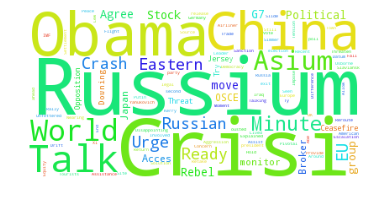

In [23]:
articles = get_articles_for_period(datetime(2014, 1, 1), datetime(2015, 1, 1))
articles = remove_duplicates(articles)
word = 'ukraine'
semantics = compute_word_semantics(articles, word)

print 'Positive mentions for word', word, 'is equeal to', semantics['pos']
print 'Negative mentions for word', word, 'is equeal to', semantics['neg']
print 'Neutral mentions for word', word, 'is equeal to', semantics['neutral']

print_word_cloud_for_words(semantics['words'], [word.lower()])

print '\n', '\n'.join([x[0]['title'] + ' ' + str(x[1]) for x in semantics['articles']])